## Clay Sciences video annotation demo notebook

### Requirements: 
* Have all the python packaged imported below
* Extract all frames of the ref video to folder FRAMES_DIR
* For the second part, have fastai 1 installed and configured to use a GPU. See  https://github.com/fastai/fastai/tree/master/old
* To launch an AWS instance configured for fastai, see https://github.com/reshamas/fastai_deeplearn_part1/blob/master/tools/aws_ami_gpu_setup.md

## Setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import json
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib
import random
from pathlib import Path

In [2]:
BASE_DIR = Path('data/new')
FRAMES_DIR = Path('data/new')
images = list(FRAMES_DIR.glob("*.jpg"))
# how are images named? change this if it doesn't match your files
ftemplate = "file%03d" 
print("Found {} images".format(len(images)))

Found 240 images


## Helper methods

In [45]:
colors = ['white', 'cyan', 'red', 'orange']

def cs_draw_idx(i, figsize=(8,8), ax=None):
    """
    Plot image i in the given axis
    """
    stem = stem_ids[i]
    img = stem_dict[stem]
    xywh = get_wh(labels_dict[stem])
    im_a = (labels_dict[stem][0], xywh)
    im = Image.open(img)
    cs_draw_im(im, [im_a], figsize=figsize, ax=ax)
    
def cs_draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def cs_draw_rect(ax, b, edgecolor='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=edgecolor, lw=1))
    cs_draw_outline(patch, 2)
    
def cs_draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    cs_draw_outline(text, 2)

def cs_show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax    

def cs_draw_im(im, ann, figsize=(16,8), ax=None):
    sz = figsize[0] if figsize else 10
    sz = min(16, max(sz, 8))
    ax = cs_show_img(im, figsize=figsize, ax=ax)
    skip_labels =(len(ann) > 1)
    i = 0   
    for b in ann:
        edgecolor = colors[i % len(colors)]
        i += 1
        coords = b[1]
        lable = b[0]
        cs_draw_rect(ax, coords, edgecolor=edgecolor)
        if not(skip_labels):
            cs_draw_text(ax, coords[:2]+[1,1], lable, sz=sz)


def get_wh(coords, from_size=None, to_size=None):
    """ get x,y,w,h from raw annotations. If both from_size and to_size are provided, resize"""
    ratio = [1.0, 1.0]
    if from_size and to_size:
        ratio = [t / f for t, f in zip(to_size, from_size)]
    [x,y,w,h] = [
        ratio[0]*float(coords[1]),
        ratio[1]*float(coords[2]),
        ratio[0]*float(coords[3]),
        ratio[1]*float(coords[4])
    ]
    [x,y,w,h] = [round(xx) for xx in [x,y,w,h]]
    return np.array([x,y,w,h])

def get_bb_yx_as_str(coords):
    [x1,y1,x2,y2] = wh_2bb(coords)
    yxbb = [y1,x1,y2,x2]
    return " ".join([str(o) for o in yxbb])

def wh_2bb(bb): return np.array([bb[0],bb[1], bb[2]+bb[0]-1, bb[3]+bb[1]-1])

def bb_2wh(a): return np.array([a[0], a[1],a[2]-a[0]+1,a[3]-a[1]+1])

def yxbb_2wh(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])


## Part I : Data Exploration

In [18]:
# json annotation file downloaded from Clay Sciences
data_file="data/new/Time Square-November-06-2018.json" 

In [19]:
json_data=open(data_file).read()
data = json.loads(json_data)
# review a few frames
data[:2]

[{'Frame': '0',
  'ID': '215_0.1_1_0',
  'Label': {'0': {'class': 'Taxi',
    'explicit': True,
    'geometry': [1034.67, 580.27, 172.8, 149.33],
    'out of frame': False}},
  'Labeled Data': 'https://claysc-cors.s3.amazonaws.com/videos/time_square_short.mp4'},
 {'Frame': '1',
  'ID': '215_0.1_1_1',
  'Label': {'0': {'class': 'Taxi',
    'explicit': False,
    'geometry': [1034.9, 580.72, 172.16, 148.78],
    'out of frame': False}},
  'Labeled Data': 'https://claysc-cors.s3.amazonaws.com/videos/time_square_short.mp4'}]

In [20]:
# collect results from json format for one object
labels_dict = {}
# fix which object to look for (id = 0)
obj_id = "0"
for d in data:
    # get frame number
    frame = d["Frame"]
    obj = d["Label"][obj_id]
    coordinates = obj["geometry"]
    fname = (ftemplate % (int(frame) + 1))
    labels_dict[fname] = [obj["class"]] + coordinates

print("%d frames for object %s" % (len(labels_dict), obj_id))

list(labels_dict.items())[:2]

240 frames for object 0


[('file001', ['Taxi', 1034.67, 580.27, 172.8, 149.33]),
 ('file002', ['Taxi', 1034.9, 580.72, 172.16, 148.78])]

## get dictionaries of stem->image, id->stem, annotations lists

In [21]:
stem_dict = { img.stem : img for img in images }
stem_list = list(stem_dict.keys())
stem_ids = {i : stem_list[i] for i in range(len(stem_list))}

In [22]:
%%script false 


images_bb_dict = { img : wh_2bb(labels_dict[img.stem][1:]) for img in images}
images_str_yx_dict = { img : get_bb_yx_as_str(labels_dict[img.stem][1:]) for img in images}

## test conversion from file name -> bb

In [23]:
img_name = images[0]
print(img_name)
im = Image.open(img_name)
imsize = im.size
print('image size', imsize)

data/new/file119.jpg
image size (1920, 1080)


In [24]:
stem = img_name.stem
ann_raw = labels_dict[stem]
print(ann_raw)

['Taxi', 1112.65, 601.55, 142.17, 122.86]


In [25]:
wh_rect = get_wh(ann_raw)
print("on %s image: %s" %(imsize, wh_rect))

wh_rect2 = get_wh(ann_raw, imsize, [100,100])
print("if (100, 100) image  : %s" % wh_rect2)


on (1920, 1080) image: [1113  602  142  123]
if (100, 100) image  : [58 56  7 11]


In [44]:
print("on {} bb: {}".format(imsize, images_bb_dict[stem_dict[stem]]))

NameError: name 'images_bb_dict' is not defined

### test displaying images by index

image id 97
image id 19
image id 153
image id 114


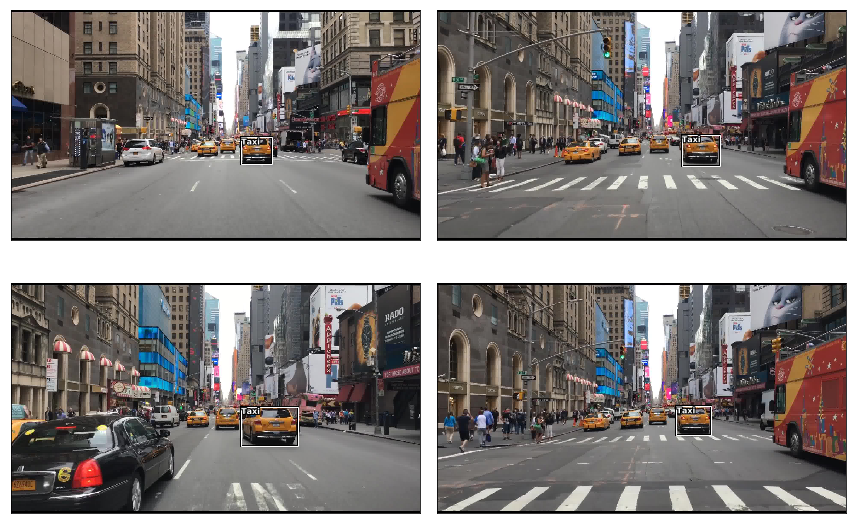

In [27]:
fig,axes = plt.subplots(2,2,figsize=(12,8))
for i,ax in enumerate(axes.flat):
    imgidx = random.randint(0, len(images)-1)
    print("image id", imgidx)
    cs_draw_idx(imgidx, ax=ax)
plt.tight_layout()

## Part II : train a model using fastai framework

### Requirements: 
* fast.ai version 1 installed. see https://github.com/fastai/fastai/tree/master/old
* To launch an AWS instance configured for fastai, see https://github.com/reshamas/fastai_deeplearn_part1/blob/master/tools/aws_ami_gpu_setup.md


### setup and define parameters (size, batch size, etc)

In [30]:
from fastai.conv_learner import *
from fastai.dataset import *
f_model = resnet34
sz=224
bs=64

### do we have what we need? 

In [31]:
torch.cuda.is_available()

True

In [32]:
# create tmp folder in BASE_DIR
tmp_path = BASE_DIR/'tmp'
if not os.path.exists(tmp_path):
    os.mkdir(tmp_path)

## Train an (overly) simple Fastai model
## Note that this network has extremely simple 'head' architecture and works well when there's only a single object to detect in each frame. 

## When there are two or more objects, it picks some combination of their corners and fails miserably.

In [41]:
def get_yxhw(img):
#     st = img.stem
    return get_bb_yx_as_str(get_wh(labels_dict[img.stem]))
    

#evaluate_on_images(train_images, val_images, skip_trainining=skip_trainining)
def evaluate_on_images(train_images, val_images):
    train_and_val_images = train_images + val_images
    val_offset_idx = len(train_images) 
    # get indices of all training images: offset+1,...
    val_idxs = np.array(range(len(val_images))) + val_offset_idx
    
    # TODO:: add class column
    df = pd.DataFrame({'fn': [fn.name for fn in train_and_val_images ], 
                       'bbox': [get_yxhw(img) for img in train_and_val_images]},
                       # 'bbox': [images_str_yx_dict[img] for img in train_and_val_images]},
                       columns = ['fn', 'bbox'])
    
    bb_df = BASE_DIR/'tmp/train_images.csv'
    print('storing in ', bb_df)
    df.to_csv(bb_df, index=False)
    
    
    augs = [RandomFlip(tfm_y=TfmType.COORD),
            RandomRotate(30, tfm_y=TfmType.COORD),
            RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs,  tfm_y=TfmType.COORD)
    md = ImageClassifierData.from_csv(FRAMES_DIR, "", bb_df, tfms=tfms, continuous=True, bs=bs,
                                      val_idxs=val_idxs)

    print("Training data: ", len(md.trn_dl.dataset.fnames))
    md.trn_dl.dataset.fnames[:5]
    print("Validation data: ", len(md.val_dl.dataset.fnames))
    md.val_dl.dataset.fnames[:5]

    ## recreating a clean neural net here ? ##
    head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
    learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
    learn.opt_fn = optim.Adam
    learn.crit = nn.L1Loss()

    saved_model_name = 'clay_sciences_fastai.model'
    lr = 5e-3
    learn.fit(lr, 2, cycle_len=1, cycle_mult=2)
    lrs = np.array([lr/100,lr/10,lr])
    learn.freeze_to(-2)
    learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

    learn.save(saved_model_name)

    print("done - saved model in ", saved_model_name)
    return bb_df, learn, md

shuffled_images = list(images) # make a copy of images
random.shuffle(shuffled_images)
# devide dataset into train and validation sets (80% training and 20% validation)
n = len(shuffled_images)
trainsize = round(n*0.8)
print(n, trainsize)
train_images = shuffled_images[:trainsize]
val_images = shuffled_images[trainsize:]
# train the model
bb_df, learn, md = evaluate_on_images(train_images, val_images)

240 192
storing in  data/new/tmp/train_images.csv
Training data:  192
Validation data:  48


A Jupyter Widget

epoch      trn_loss   val_loss                          
    0      95.061625  18.836523 
    1      87.903542  123.759407                        
    2      97.407863  98.570168                         



A Jupyter Widget

epoch      trn_loss   val_loss                          
    0      75.067533  52.368118 
    1      57.066168  48.884991                         
    2      48.769527  25.585373                         

done - saved model in  clay_sciences_fastai.model


### Change this learner to be in evaluation mode - training is over, now it's infering time

In [61]:
learn.model.eval()
learn.summary()



OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

## show some images from training set

(224, 224)  bb = [  83.  135.   18.   30.]
(224, 224)  bb = [  73.  134.   29.   47.]
(224, 224)  bb = [ 123.  107.   22.   35.]
(224, 224)  bb = [ 118.  134.   18.   31.]
(224, 224)  bb = [  84.  122.   18.   26.]
(224, 224)  bb = [  69.  122.   19.   29.]
(224, 224)  bb = [  85.  122.   17.   26.]
(224, 224)  bb = [  79.  125.   15.   22.]
(224, 224)  bb = [ 125.  107.   20.   33.]


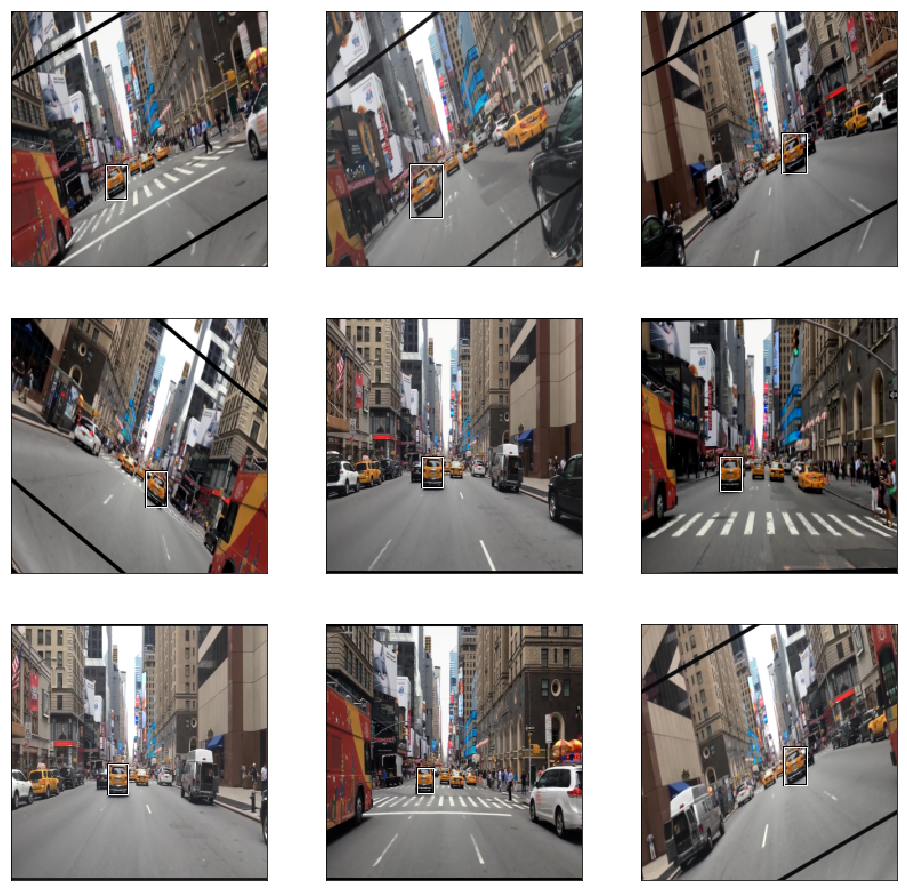

In [63]:
fig,axes = plt.subplots(3,3, figsize=(16,16))
idx=3
trn_iter = iter(md.trn_dl)
x,y = next(trn_iter)
idx = 0
for i,ax in enumerate(axes.flat):
    # get new batch
    idx = i
    if i >= len(x):
        x,y = next(trn_iter)
        idx = 0

    im = md.trn_ds.denorm(to_np(x))[idx]
    b=yxbb_2wh(y[idx])
    print("{}  bb = {}".format(im.shape[:2], b))
    cs_show_img(im, ax=ax)
    cs_draw_rect(ax,b)

### show some images from validation set

(224, 224)  prediction = [ 109.80174  122.27422    7.28603  -56.67876]
(224, 224)  prediction = [ 127.83807  128.92267    7.91063  -50.94607]
(224, 224)  prediction = [ 125.14663  125.75144    8.48002  -48.8047 ]
(224, 224)  prediction = [ 116.72332  118.70167   11.26669  -51.77154]
(224, 224)  prediction = [ 112.14072  121.79734    6.38746  -28.85812]
(224, 224)  prediction = [ 128.2597   127.54187    6.12927  -37.6792 ]


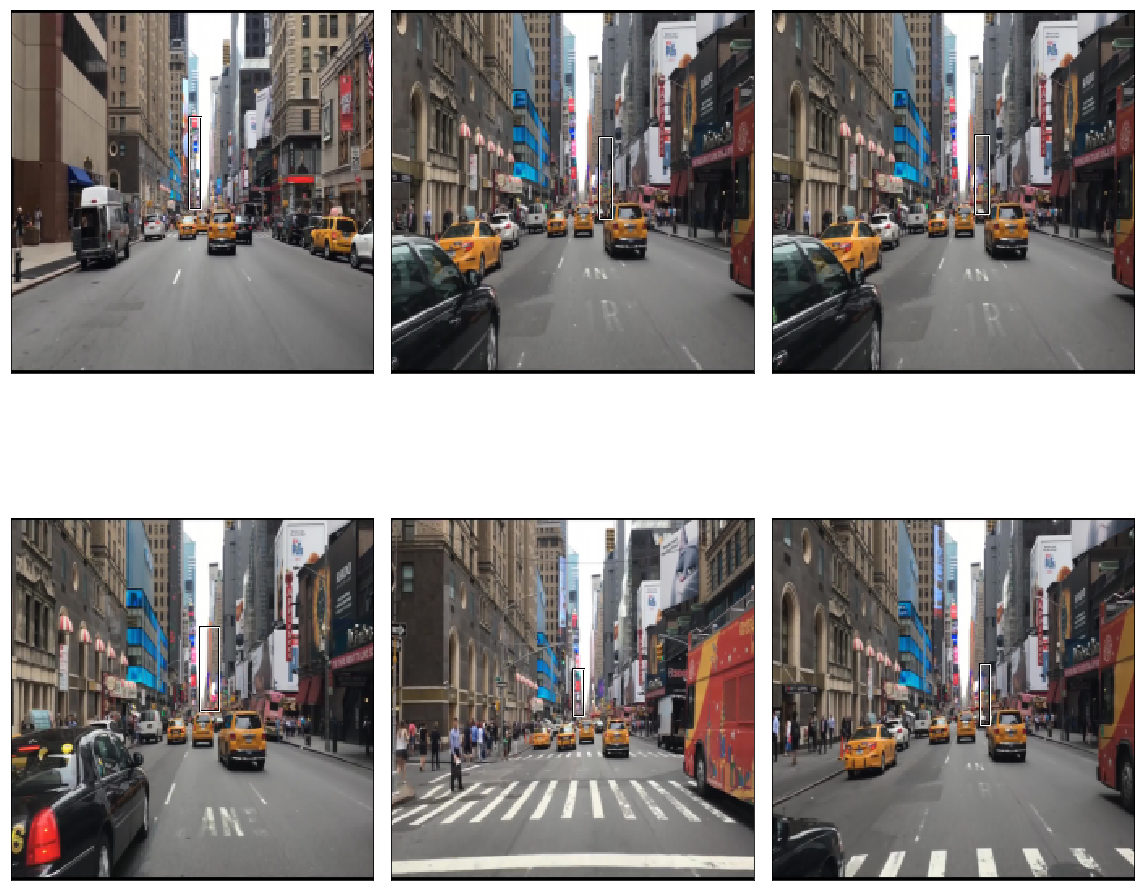

In [62]:
val_iter = iter(md.val_dl)
x,y = next(val_iter)
idx = 0
fig, axes = plt.subplots(2,3, figsize=(16,16))
for i,ax in enumerate(axes.flat):
    idx = i
    if i >= len(x):
        x,y = next(val_iter)
        idx = 0
    preds = to_np(learn.model(VV(x)))
    im = md.val_ds.denorm(to_np(x))[idx]
    
    b = yxbb_2wh(preds[idx])
    print("{}  prediction = {}".format(im.shape[:2], b))
    cs_show_img(im, ax=ax)
    cs_draw_rect(ax,b)
    
    #draw_im(im, [b], ax=ax, figsize=(6,6))
plt.tight_layout()